### I. Libary import

In [13]:
from clearml import Task
import numpy as np
import random
import os
import optuna

import joblib
import pandas as pd
import optuna.visualization as vis
import matplotlib.pyplot as plt

from pathlib import Path
from clearml import Logger
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
# from xgboost import XGBRegressor

from src import data_preprocessing as dp
from src import pipeline as pl
from src import new_feature_engineering_daily as fe
from src import feature_selection as fs
from src.model_evaluation import evaluate, evaluate_multi_output
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED) 

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)


### I. Data prepare

- EDA của hourly và daily sẽ để riêng, đây là file report lại các bước làm

- Vẽ t cái biểu đồ tóm tắt các step gọi hàm kiểu như này (ảnh lấy đại trên mạng thôi, làm tương tự nhé)

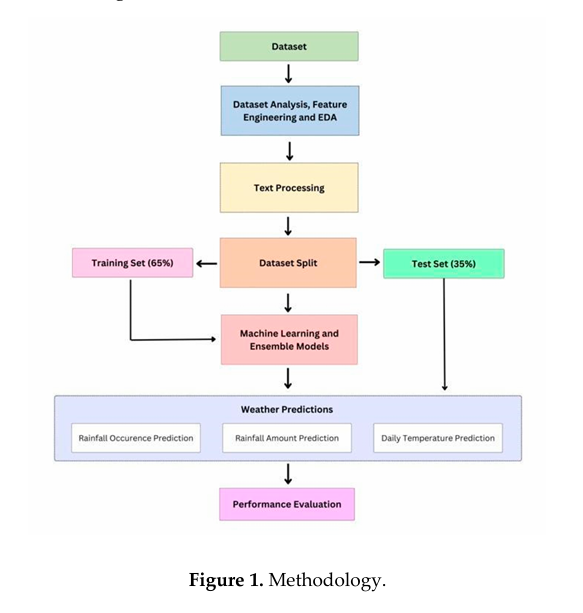

- Ghi cho t mỗi step gọi hàm gì, nó có những nhiệm vụ gì, input đầu vào, output đầu ra như nào (ghi xen kẽ với từng câu lệnh gọi hàm luôn, hoặc viết chung vào biểu đồ tóm tắt, ...Tự xem xét để Ngắn gọn, Dễ hiểu)

- (VD: Step 1: dp.load_data lấy relative path data 10 năm, trả ra output là 1 Dataframe, gồm bao nhiều dòng, bao nhiêu cột )

- Bổ sung cho t câu lệnh kiểu như print('số lượng sau drop', X_train.shape, X_test.shape) sau mỗi câu lệnh bên dưới để nắm được số lượng 

In [14]:
# 1. Load raw Data
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")

# 2. basic preprocessing for all data set
df = dp.basic_preprocessing(df=df)

# 3. Chia train, test theo thời gian (80/20)
train_size = 0.8
n = len(df)

train_df = df.iloc[:int(train_size * n)]
test_df = df.iloc[int(train_size * n):]

# 4. Fit preprocessing pipeline trên train
pipeline1 = pl.build_preprocessing_pipeline()
pipeline1.fit(train_df)

# 5. Transform cả train và test
train_processed = pipeline1.transform(train_df)
test_processed = pipeline1.transform(test_df)

# 6. Chia train, test theo thời gian (80/20)
train_size = 0.8
n = len(df)

train_df = df.iloc[:int(train_size * n)]
test_df = df.iloc[int(train_size * n):]

# 7. Fit preprocessing pipeline trên train
pipeline1 = pl.build_preprocessing_pipeline()
pipeline1.fit(train_df)

# 8. Transform cả train và test
train_processed = pipeline1.transform(train_df)
test_processed = pipeline1.transform(test_df)

# 9. Lưu lại pipeline 1
# joblib.dump(pipeline1, r"pipelines\preprocessing_pipeline.pkl")

 Loaded data with shape: (3660, 33)
Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'


### II. Feature Engineering and Training Model

### II.1. OVERVIEW

### 1. Phương pháp dự đoán 
- 3 cái phương pháp chính mà Kiên gửi ảnh, viết na ná kiểu vậy, giải thích kĩ - ngắn gọn cách mà mình chọn (mình là direct, dùng huấn luyện riêng 5 model)

### 2. Giải thích các Metrics mình dùng (MAE, RMSE, R^2) - Sương Mai 
Công thức, nêu ý nghĩa, bảng so sánh vv

Nhóm mình dùng hàm evaluate_multi_output trong file model_evaluation, input đầu vào, output đầu ra?  

Nhóm mình ưu tiên tối ưu metric nào, vì sao 

Chắc vẫn lựa chọn tối ưu theo RMSE, lúc giải thích kết quả thì vẫn sử dụng tất cả để đánh giá 

### 3. Cách đánh giá
Ngoài việc chia train, test thì trong quá trình tuning và so sánh giữa các phương pháp mình sẽ sử dụng Cross-Val trên train. Vẽ cho t cái biểu đồ tiếp (nếu biểu đồ tổng quát có cụ thể rồi thì thôi)


Đây là đoạn t viết để giải thích chung chung, (ai đọc thì check xem t vt đúng luôn không) cho mọi người. Người viết tóm tắt ngắn gọn lại quy trình thôi

- Workflow: Trong quá trình so sánh các phương án, tuning chỉ dùng dữ liệu trên tập train (tập này sẽ được chia thành 5 cross-validation - tức 5 cặp train/ test nhỏ - và mình sẽ đánh giá mức độ dự đoán và ổn định của model trên các cặp train/ test này) 

=> Tìm được phương án tốt nhất rồi thì mới training lại và đánh giá lần cuối trên toàn bộ train và test set. 

- Phần so sánh việc drop base, hay xử lí cate: Mấy bạn viết report kết quả, Ngoài việc sử dụng (Metrics trung bình của 5 tập hay Std của 5 tập - thể hiện mức độ biến động/ ổn định giữa các fold) tìm thêm biểu đồ biểu như kiểu box plot (thầy Long) để trực quan hoá, nhớ là kèm giải thích ngắn gọn

### 4. Hyperparameter Tuning Tools
#### 4.1. Optuna

Optuna was adopted as the main framework for hyperparameter optimization. It offers a flexible architecture and supports advanced optimization algorithms, notably the Tree-structured Parzen Estimator (TPE). Compared to conventional approaches such as Grid Search or Random Search, Optuna dynamically constructs a probabilistic model of the objective function and uses it to propose new, potentially better hyperparameter configurations. This approach narrows the search space and improves convergence efficiency.

In practice, each trial corresponds to a single model training run under a specific set of hyperparameters. The objective function evaluates model performance (for example, validation loss or accuracy) and returns a scalar value that guides the optimization process. Optuna’s sampler component determines how new hyperparameter values are generated based on the results of previous trials, balancing exploration and exploitation.

A key advantage of Optuna lies in its asynchronous pruning mechanism, which automatically stops trials that show poor intermediate results. This feature substantially reduces unnecessary computation while maintaining optimization quality.
##### 4.2. ClearML

We employed ClearML to systematically record and manage all hyperparameter tuning experiments. The platform served as a centralized environment for logging, monitoring, and comparing tuning results across multiple runs. By integrating ClearML into the workflow, we ensured that every tuning session was automatically tracked, enabling clear visualization of performance differences between experiments and maintaining full reproducibility of the results.

*Figure 4.2.1.* ClearML project interface displaying all tuning tasks managed by the team.

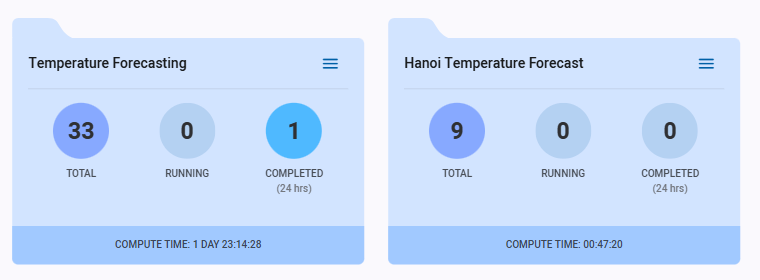 

*Left: training data folder. Right: retraining data folder.*

*Figure 4.2.2.* Main interface of the first folder.
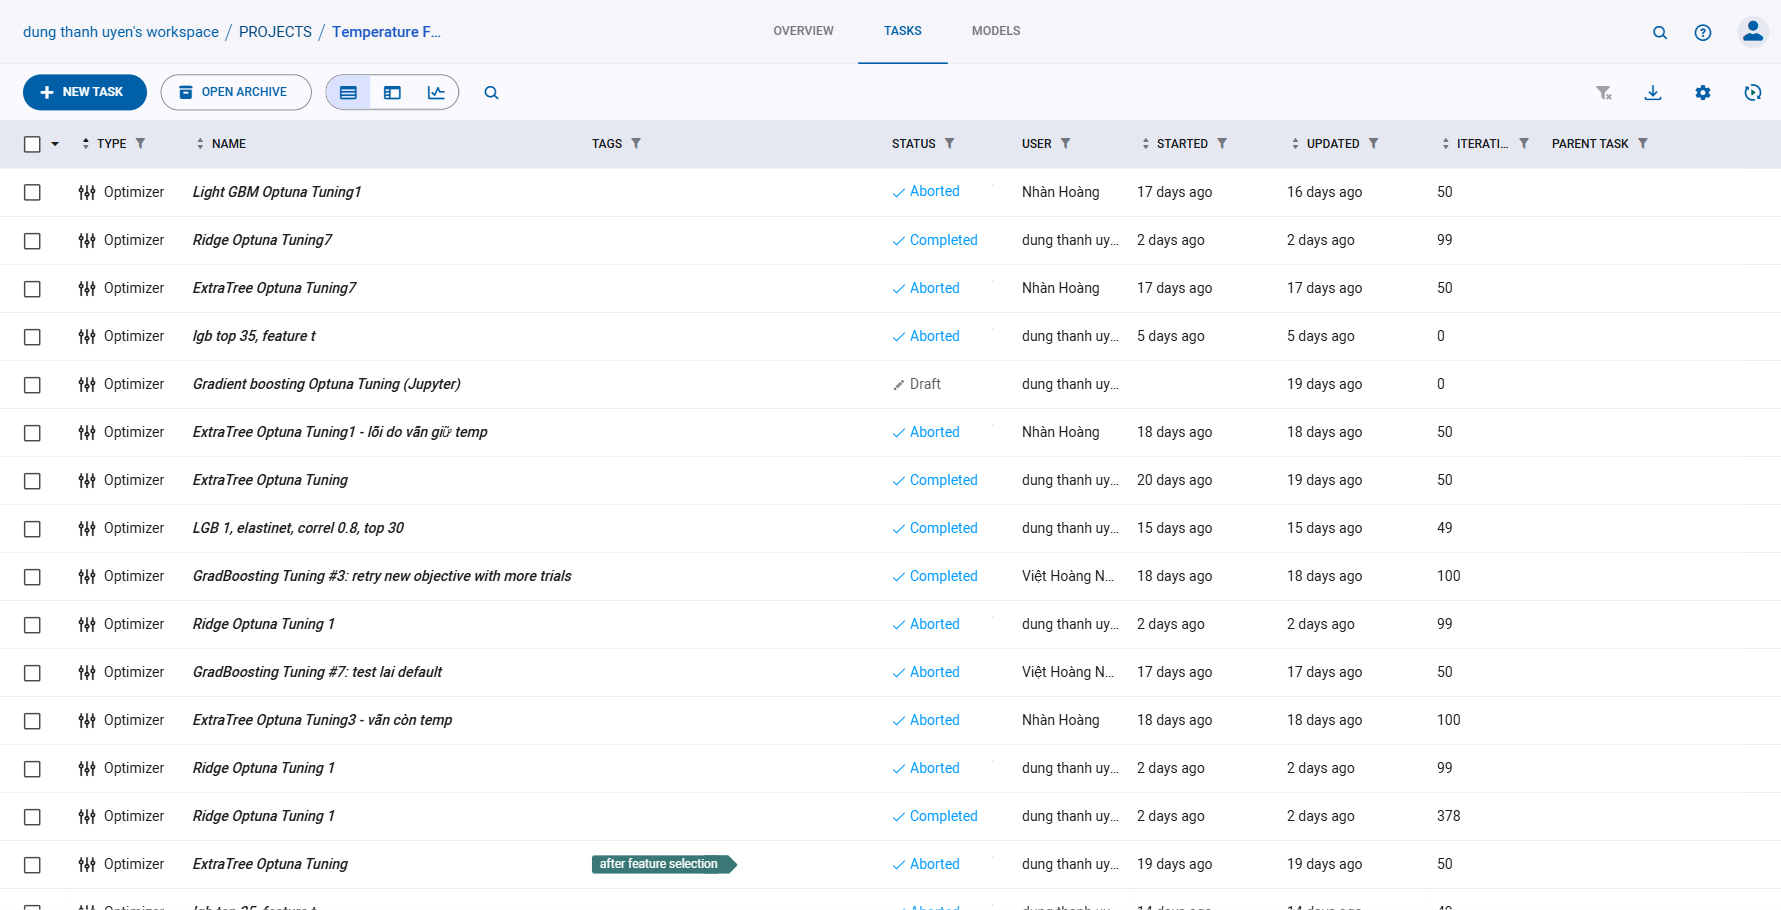
*Main interface of the first folder.*


We used ClearML to automatically record and manage all experiment data during the tuning process. The platform was integrated into our workflow to ensure every run was tracked, reproducible, and visually comparable.

Artifacts: ClearML stored all essential experiment outputs, including best hyperparameters, training and testing metrics, and feature selection results. These files were automatically uploaded after each tuning run, allowing us to retrieve and review model configurations and results later.

*Figure 4.2.1.* Artifacts 

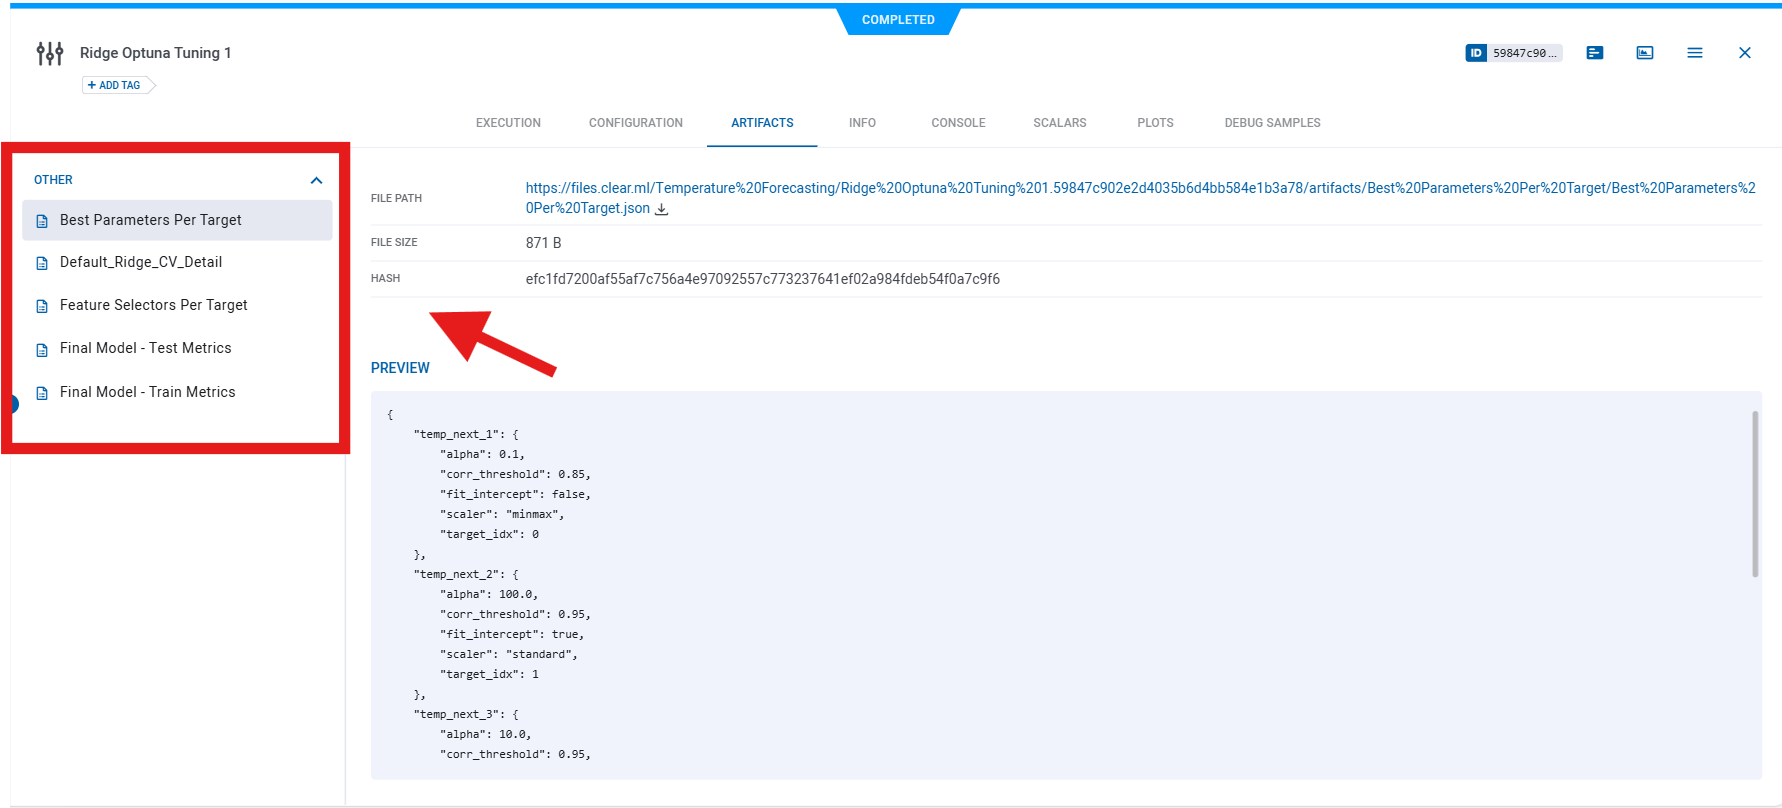

**Scalar Logs and Plots**: We used ClearML to visualize quantitative metrics such as RMSE across different targets (temp_next_1–temp_next_5). The plots (Figure 4.2.2) show how RMSE values changed throughout the tuning iterations, helping us analyze convergence behavior and select the best-performing trials.

*Figure 4.2.1.* Scalar Logs and Plots

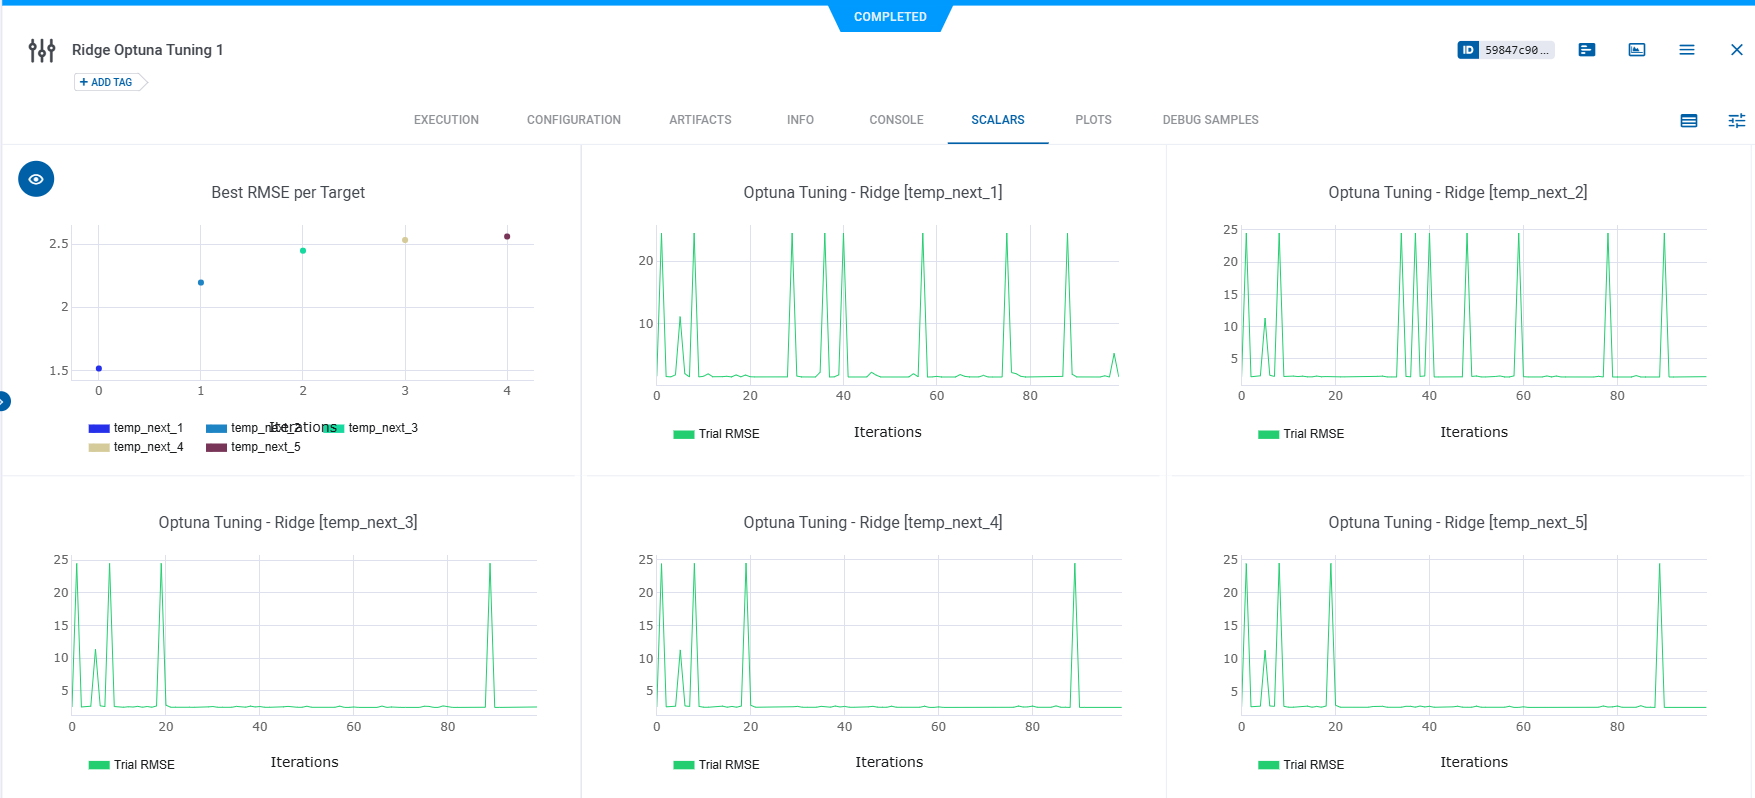

To create and log a new tuning task in ClearML, we initialized it in our training script using the following code snippet:
```python
if Task.current_task():
    Task.current_task().close()

task_lgbm = Task.init(
    project_name="Temperature Forecasting",         # tên project trên ClearML (nếu chưa có sẽ tự tạo)
    task_name="Ridge Optuna Tuning 1",            # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print(" Task created successfully!")
print("Task ID:", task_lgbm.id)

task_lgbm = Task.get_task(task_id="59847c902e2d4035b6d4bb584e1b3a78")
```

This command automatically connected the local experiment to the ClearML server, enabling real-time logging of parameters, metrics, and artifacts throughout the tuning process.

Through ClearML integration, the entire tuning workflow became fully reproducible and transparent, ensuring that all parameter configurations, metrics, and artifacts could be retrieved and analyzed after each run.

### II.2. Feature engineering and Training

### 1. Linear Model 

### 1.1. Giới thiệu Ridge - Sương Mai, Nhàn


### 1.2. Input preparation (Feature Engineering and Selection) for linear model (Ridge)

To enhance the performance of the Ridge Regression model, several feature engineering and preprocessing steps were implemented.  
The objective was to improve model interpretability and enable the linear model to capture potential non-linear relationships between meteorological variables.

---

#### (a) Interaction Feature Construction

To help the linear model account for multiplicative and non-linear relationships, interaction terms were introduced between key meteorological features.  

```python
df['wind_temp_index'] = df['windspeed'] * df['temp']
df['pressure_temp_index'] = df['sealevelpressure'] * df['temp']
df['humidity_cloud_index'] = (df['humidity'] * df['cloudcover']) / 100
df['solar_temp_index'] = df['solarradiation'] * df['temp']
df['temp_humidity_interaction'] = df['temp'] * df['humidity']
df['wind_temp_interaction'] = df['winddir'] * df['temp']
df['temp_dew_interaction'] = df['temp'] * df['dew'] 
```

#### (b) Encoding of Categorical and Derived Features

To ensure the Ridge model could process all input variables effectively, a custom **encoding pipeline** was developed and applied prior to model training.  
This pipeline (`build_encoding_pipeline`) automatically handled the transformation of categorical and domain-derived features into numeric form while preserving meaningful structure across the data.

The pipeline consisted of three core components:

1. **ConditionsEncoder**  
   Encoded the `conditions` feature based on the specified method (`target`, `ordinal`, or `quantile`).  
   When `is_category=True`, categorical values were preserved; otherwise, they were numerically encoded using the chosen method.  
   This encoding allowed the model to reflect the statistical relationship between weather conditions and the target variable.

2. **SeasonClassifier**  
   Classified months into *n* seasonal groups (`n_seasons=5`) according to the average temperature patterns.  
   If `is_category=True`, the season variable was cast as categorical; otherwise, it was encoded numerically to represent cyclical temperature behavior across seasons.

3. **WindCategoryEncoder**  
   Derived from the `winddir` feature, this encoder grouped wind directions into eight domain-defined wind categories.  
   Depending on configuration, it either retained categorical form or encoded the distribution numerically based on quantile segmentation (`n_quantiles=4`).

- Feature Selection (Drop Highly Correlated và Drop Base Feature)
#### (c) Feature Selection

Feature selection was applied to reduce redundancy and multicollinearity.
Highly correlated variables were identified and dropped using pairwise correlation analysis (Drop Highly Correlated).
Additionally, redundant base features were removed where corresponding interaction terms already captured sufficient explanatory power (Drop Base Feature).

#### (d) Feature Scaling

Feature scaling was an essential preprocessing step to ensure uniform numerical ranges and prevent regularization bias.
The default scaler used was StandardScaler, though MinMaxScaler and RobustScaler were also tuned during the hyperparameter optimization stage to assess their impact on model performance.

In [16]:
## lưu ý khi tune linear này sẽ khác so với LGB

# 1. có sử dụng các biến interaction: is_linear = True

# Tạo feature engineering (drop NaN sau khi rolling/lag)
train_feat, target_col = fe.feature_engineering(train_processed, is_drop_nan= True, is_linear= True)
test_feat, _ = fe.feature_engineering(test_processed, is_drop_nan= True, is_linear= True)

# Chia X, y riêng biệt
X_train = train_feat.drop(columns= target_col)
y_train = train_feat[target_col]

X_test = test_feat.drop(columns= target_col)
y_test = test_feat[target_col]


# 2. Encoding sang numeric
encoder = pl.build_encoding_pipeline(is_category= False)
encoder.fit(X_train, X_train['temp'])

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)


print(f"Train: {X_train.shape, y_train.shape}, Test: {X_test.shape, y_test.shape}")

cat_features = X_train.select_dtypes(include=['category','object']).columns
print('\nKiểm tra còn biến object hay category', len(cat_features))


# 3. Drop base
print('\nDrop Base')
print('số lượng Trước Khi drop base', X_train.shape, X_test.shape)
X_train = fe.drop_base_features(X_train)
X_test = fe.drop_base_features(X_test)
print('số lượng sau drop base', X_train.shape, X_test.shape)



Đã tạo 7 biến interaction
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
Đã tạo 7 biến interaction
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
Train: ((2893, 264), (2893, 5)), Test: ((697, 264), (697, 5))

Kiểm tra còn biến object hay category 0

Drop Base
số lượng Trước Khi drop base (2893, 264) (697, 264)
số lượng sau drop base (2893, 243) (697, 243)


#### 1.3. Tuning trên cross-validation

In [17]:
# Nhớ đổi tên task trong task_name

if Task.current_task():
    Task.current_task().close()

task_lgbm = Task.init(
    project_name="Temperature Forecasting",         # tên project trên ClearML (nếu chưa có sẽ tự tạo)
    task_name="Ridge Optuna Tuning 8",            # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print(" Task created successfully!")
print("Task ID:", task_lgbm.id)

ClearML Task: overwriting (reusing) task id=4a9a2b4c2c4b4ea7b045fb886ba1b70f
ClearML results page: https://app.clear.ml/projects/01d8ce929f0243de9a9d3adf48970730/experiments/4a9a2b4c2c4b4ea7b045fb886ba1b70f/output/log
Task ID: 4a9a2b4c2c4b4ea7b045fb886ba1b70f


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [18]:
task_lgbm = Task.get_task(task_id="4a9a2b4c2c4b4ea7b045fb886ba1b70f")
logger_lgbm = task_lgbm.get_logger()

#### A. Chạy thử với các hyper parameter mặc định

Pipeline mặc định sẽ gồm:
 - DropHighlyCorrelated1(threshold= 0.8) : Giải thích qua nó làm gì, tại sao cần
 - StandardScaler(): giải thích làm gì tạo sao cần
 - Ridge (alpha = 1.0, fit_intercapt = True)

In [19]:
# === 1️ Cấu hình Ridge mặc định ===
default_model_params = dict(
    alpha=1.0,
    fit_intercept=True,
    random_state=42
)

# === 2️ Cấu hình Feature Selection ===
fs_params = dict(
    corr_threshold=0.8,  # Cần tuning threshold
)

# === 3️ Pipeline gồm feature selection + scaler + Ridge ===
ridge_pipeline = Pipeline([
    ("feature_selection", fs.DropHighlyCorrelated1(threshold=fs_params['corr_threshold'])),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(**default_model_params))
])

# === 4 Time Series Cross Validation ===
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []
cv_artifacts = {}

print("=== Time Series Cross-Validation (Ridge + Scaling) ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Huấn luyện riêng cho từng target
    y_pred_val_all = pd.DataFrame(index=y_val.index, columns=y_train.columns)
    for target_col in y_train.columns:
        model = ridge_pipeline
        model.fit(X_tr, y_tr[target_col])
        y_pred_val_all[target_col] = model.predict(X_val)

    # Đánh giá
    metrics_val = evaluate_multi_output(y_val, y_pred_val_all)
    avg_val = metrics_val["average"]
    per_day_val = metrics_val["per_day"]
    cv_scores.append(avg_val)

    print(f"\nFold {fold_idx} validation metrics:")
    print(avg_val)
    print(per_day_val)

    # Log artifact thay vì scalar
    cv_artifacts[f"Fold_{fold_idx}"] = {
        "average": avg_val,
        "per_day": per_day_val
    }

    fold_idx += 1


# === 5 Tổng hợp kết quả cross-validation ===
cv_df = pd.DataFrame(cv_scores)
cv_mean = cv_df.mean()
cv_std = cv_df.std()

print("\n=====> Cross-validation trung bình:")
print(cv_mean)
print("\n=====> Cross-validation độ lệch chuẩn:")
print(cv_std)

# Log artifact tổng hợp CV (mean + std)
cv_artifacts["CV_Summary"] = {
    "mean": cv_mean.to_dict(),
    "std": cv_std.to_dict()
}

# Gửi toàn bộ artifact CV lên ClearML
task_lgbm.upload_artifact("Default_Ridge_CV_Detail", cv_artifacts)


=== Time Series Cross-Validation (Ridge + Scaling) ===

Fold 1 validation metrics:
{'RMSE': np.float64(2.5853330099520555), 'MAE': np.float64(2.0732011808608215), 'R2': np.float64(0.7124205810815589)}
{'RMSE_day_1': np.float64(1.724918375374978), 'MAE_day_1': 1.3583275386006894, 'R2_day_1': 0.8754300160544013, 'RMSE_day_2': np.float64(2.4733444905661), 'MAE_day_2': 1.9914411006894905, 'R2_day_2': 0.7440501218797855, 'RMSE_day_3': np.float64(2.7949228397176094), 'MAE_day_3': 2.2372329478334527, 'R2_day_3': 0.6744572603371295, 'RMSE_day_4': np.float64(2.9141988285875864), 'MAE_day_4': 2.327786873954971, 'R2_day_4': 0.6470184344939018, 'RMSE_day_5': np.float64(3.0192805155140023), 'MAE_day_5': 2.4512174432255023, 'R2_day_5': 0.6211470726425767}

Fold 2 validation metrics:
{'RMSE': np.float64(2.6136939524285276), 'MAE': np.float64(2.073027343479027), 'R2': np.float64(0.6817881372447763)}
{'RMSE_day_1': np.float64(1.7353412134561357), 'MAE_day_1': 1.352249221773457, 'R2_day_1': 0.8646072839

True

### B. Tuning với Scaler, Drop Highly Correlated threshold, Model Ridge

In [ ]:
## === A. Optuna Objective cho từng target RIÊNG BIỆT ==
def objective_ridge_per_target(trial, target_name, target_idx):
   # Chọn scaler 
   scaler_name = trial.suggest_categorical("scaler", ["standard", "minmax", "robust"])
   if scaler_name == "standard":
      scaler = StandardScaler()
   elif scaler_name == "minmax":
      scaler = MinMaxScaler()
   else:
      scaler = RobustScaler()

   # Hyperparameter cho Ridge
   alpha = trial.suggest_float("alpha", 1e1, 1e2, log=True)
   fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
   
   # Hyperparameter cho Feature Selection - THÊM VÀO
   corr_threshold = trial.suggest_float("corr_threshold", 0.7, 0.95, step=0.05)  

   # TimeSeriesSplit
   cv = TimeSeriesSplit(n_splits=5)
   rmse_scores = []

   for train_idx, val_idx in cv.split(X_train):
      X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
      # Áp dụng feature selection cho từng fold - THÊM VÀO
      high = fs.DropHighlyCorrelated1(threshold=corr_threshold)
      X_tr_fs = high.fit_transform(X_tr)
      X_val_fs = high.transform(X_val)

      # Chỉ lấy target hiện tại
      y_tr_single = y_tr.iloc[:, target_idx] if len(y_tr.shape) > 1 else y_tr
      y_val_single = y_val.iloc[:, target_idx] if len(y_val.shape) > 1 else y_val

      # Pipeline: scaler + Ridge (Single output)
      ridge = Ridge(
         alpha=alpha,
         fit_intercept=fit_intercept,
         random_state=42
      )
      pipeline = Pipeline([
         ("scaler", scaler),
         ("model", ridge)
      ])

      pipeline.fit(X_tr_fs, y_tr_single)
      y_pred_val = pipeline.predict(X_val_fs)

      # Tính RMSE cho target hiện tại
      result = evaluate(y_val_single, y_pred_val)
      rmse = result['RMSE']
      rmse_scores.append(rmse)

   mean_rmse = np.mean(rmse_scores)

   # Log lên ClearML với series theo target
   logger_lgbm.report_scalar(
      title=f'Optuna Tuning - Ridge [{target_name}]',
      series='Trial RMSE',
      value=mean_rmse,
      iteration=trial.number
   )

   params_table = pd.DataFrame([{
      "target": target_name,
      "scaler": scaler_name,
      "alpha": alpha,
      "fit_intercept": fit_intercept,
      "corr_threshold": corr_threshold, 
   }])
   
   logger_lgbm.report_table(
      title=f"Trial {trial.number} - {target_name}",
      series="params",
      iteration=trial.number,
      table_plot=params_table
   )

   return mean_rmse


In [21]:
## === B. Hàm helper ===
def get_scaler_from_params(scaler_name):
   if scaler_name == "standard":
      return StandardScaler()
   elif scaler_name == "minmax":
      return MinMaxScaler()
   else:
      return RobustScaler()

def extract_ridge_params(params):
   return {
      'alpha': params['alpha'],
      'fit_intercept': params['fit_intercept'],
      'random_state': 42
   }


In [22]:

## === C.. Tune riêng cho từng target ===
best_models_per_target = {}
best_params_per_target = {}
feature_selectors_per_target = {} 


# Tắt logging Nó hiện nhiều quá thì bỏ comment dòng này ra, đằng nào cũng quan sát được trên clearml
# optuna.logging.set_verbosity(optuna.logging.WARNING)


for idx, target_name in enumerate(y_train.columns):
   print(f"Tuning Ridge for target: {target_name} ({idx + 1}/{len(y_train.columns)})")
   
   # Tạo study riêng cho mỗi target
   study = optuna.create_study(
      direction='minimize',
      sampler=optuna.samplers.TPESampler(seed=42)
   )
   
   # Gọi Study Optimize 
   study.optimize(
      lambda trial: objective_ridge_per_target(trial, target_name, idx), 
      n_trials=200,
      show_progress_bar=False
   )
      
   # Lưu best params và model cho target này
   best_params_per_target[target_name] = study.best_trial.params
   best_params_per_target[target_name]['target_idx'] = idx
   
   # Fit best model cho target này với feature selection 
   best_scaler = get_scaler_from_params(study.best_trial.params["scaler"])
   best_ridge = Ridge(**extract_ridge_params(study.best_trial.params))
   
   # Áp dụng feature selection trên toàn bộ training data 
   high = fs.DropHighlyCorrelated1(threshold=study.best_trial.params["corr_threshold"])
   X_train_fs = high.fit_transform(X_train)
   
   # Lưu feature selectors để sử dụng sau
   feature_selectors_per_target[target_name] = {
      'correlation_selector': high,
   }
   
   best_pipeline = Pipeline([
      ("scaler", best_scaler),
      ("model", best_ridge)
   ])
   
   # Train trên toàn bộ data đã được feature selection
   y_target = y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
   best_pipeline.fit(X_train_fs, y_target)
   best_models_per_target[target_name] = best_pipeline
   
   # Log kết quả từng target lên ClearML
   logger_lgbm.report_scalar(
      title='Best RMSE per Target',
      series=target_name,
      value=study.best_value,
      iteration=idx
   )
   
   print(f" {target_name} - Best RMSE: {study.best_value:.4f}")
   print(f" {target_name} - Final features: {X_train_fs.shape[1]}")

# Khôi phục logging
#optuna.logging.set_verbosity(optuna.logging.INFO)


[I 2025-11-10 21:38:05,057] A new study created in memory with name: no-name-679f4094-c18d-4778-9ee5-098761caeed4


Tuning Ridge for target: temp_next_1 (1/5)


[I 2025-11-10 21:38:05,718] Trial 0 finished with value: 2.0560148629923822 and parameters: {'scaler': 'minmax', 'alpha': 26.208630215377518, 'fit_intercept': True, 'corr_threshold': 0.7}. Best is trial 0 with value: 2.0560148629923822.
[I 2025-11-10 21:38:06,380] Trial 1 finished with value: 1.8368023490080556 and parameters: {'scaler': 'standard', 'alpha': 10.336843570697404, 'fit_intercept': True, 'corr_threshold': 0.75}. Best is trial 1 with value: 1.8368023490080556.
[I 2025-11-10 21:38:07,108] Trial 2 finished with value: 1.5801500515847433 and parameters: {'scaler': 'robust', 'alpha': 23.269604681949623, 'fit_intercept': True, 'corr_threshold': 0.85}. Best is trial 2 with value: 1.5801500515847433.
[I 2025-11-10 21:38:07,825] Trial 3 finished with value: 1.5756625120146883 and parameters: {'scaler': 'robust', 'alpha': 20.834315611529476, 'fit_intercept': True, 'corr_threshold': 0.85}. Best is trial 3 with value: 1.5756625120146883.
[I 2025-11-10 21:38:08,564] Trial 4 finished wi

 temp_next_1 - Best RMSE: 1.5178
 temp_next_1 - Final features: 138
Tuning Ridge for target: temp_next_2 (2/5)


[I 2025-11-10 21:40:28,432] Trial 0 finished with value: 2.427447034685518 and parameters: {'scaler': 'minmax', 'alpha': 26.208630215377518, 'fit_intercept': True, 'corr_threshold': 0.7}. Best is trial 0 with value: 2.427447034685518.
[I 2025-11-10 21:40:30,684] Trial 1 finished with value: 2.3506183272046846 and parameters: {'scaler': 'standard', 'alpha': 10.336843570697404, 'fit_intercept': True, 'corr_threshold': 0.75}. Best is trial 1 with value: 2.3506183272046846.
[I 2025-11-10 21:40:33,086] Trial 2 finished with value: 2.24028654693938 and parameters: {'scaler': 'robust', 'alpha': 23.269604681949623, 'fit_intercept': True, 'corr_threshold': 0.85}. Best is trial 2 with value: 2.24028654693938.
[I 2025-11-10 21:40:35,716] Trial 3 finished with value: 2.239265748995958 and parameters: {'scaler': 'robust', 'alpha': 20.834315611529476, 'fit_intercept': True, 'corr_threshold': 0.85}. Best is trial 3 with value: 2.239265748995958.
[I 2025-11-10 21:40:38,490] Trial 4 finished with value

 temp_next_2 - Best RMSE: 2.1947
 temp_next_2 - Final features: 156
Tuning Ridge for target: temp_next_3 (3/5)


[I 2025-11-10 21:46:06,477] Trial 0 finished with value: 2.626156753602627 and parameters: {'scaler': 'minmax', 'alpha': 26.208630215377518, 'fit_intercept': True, 'corr_threshold': 0.7}. Best is trial 0 with value: 2.626156753602627.
[I 2025-11-10 21:46:08,752] Trial 1 finished with value: 2.598607394050525 and parameters: {'scaler': 'standard', 'alpha': 10.336843570697404, 'fit_intercept': True, 'corr_threshold': 0.75}. Best is trial 1 with value: 2.598607394050525.
[I 2025-11-10 21:46:11,196] Trial 2 finished with value: 2.5189076709394818 and parameters: {'scaler': 'robust', 'alpha': 23.269604681949623, 'fit_intercept': True, 'corr_threshold': 0.85}. Best is trial 2 with value: 2.5189076709394818.
[I 2025-11-10 21:46:13,762] Trial 3 finished with value: 2.518154809326903 and parameters: {'scaler': 'robust', 'alpha': 20.834315611529476, 'fit_intercept': True, 'corr_threshold': 0.85}. Best is trial 3 with value: 2.518154809326903.
[I 2025-11-10 21:46:16,536] Trial 4 finished with val

 temp_next_3 - Best RMSE: 2.4469
 temp_next_3 - Final features: 156
Tuning Ridge for target: temp_next_4 (4/5)


[I 2025-11-10 21:49:36,425] Trial 0 finished with value: 2.686976162419744 and parameters: {'scaler': 'minmax', 'alpha': 26.208630215377518, 'fit_intercept': True, 'corr_threshold': 0.7}. Best is trial 0 with value: 2.686976162419744.
[I 2025-11-10 21:49:37,125] Trial 1 finished with value: 2.683142717425487 and parameters: {'scaler': 'standard', 'alpha': 10.336843570697404, 'fit_intercept': True, 'corr_threshold': 0.75}. Best is trial 1 with value: 2.683142717425487.
[I 2025-11-10 21:49:37,878] Trial 2 finished with value: 2.616493139525701 and parameters: {'scaler': 'robust', 'alpha': 23.269604681949623, 'fit_intercept': True, 'corr_threshold': 0.85}. Best is trial 2 with value: 2.616493139525701.
[I 2025-11-10 21:49:38,636] Trial 3 finished with value: 2.6158214387338026 and parameters: {'scaler': 'robust', 'alpha': 20.834315611529476, 'fit_intercept': True, 'corr_threshold': 0.85}. Best is trial 3 with value: 2.6158214387338026.
[I 2025-11-10 21:49:39,421] Trial 4 finished with val

 temp_next_4 - Best RMSE: 2.5294
 temp_next_4 - Final features: 156
Tuning Ridge for target: temp_next_5 (5/5)


[I 2025-11-10 21:52:06,945] Trial 0 finished with value: 2.7049730366981897 and parameters: {'scaler': 'minmax', 'alpha': 26.208630215377518, 'fit_intercept': True, 'corr_threshold': 0.7}. Best is trial 0 with value: 2.7049730366981897.
[I 2025-11-10 21:52:07,738] Trial 1 finished with value: 2.713160102880288 and parameters: {'scaler': 'standard', 'alpha': 10.336843570697404, 'fit_intercept': True, 'corr_threshold': 0.75}. Best is trial 0 with value: 2.7049730366981897.
[I 2025-11-10 21:52:08,811] Trial 2 finished with value: 2.661498934959777 and parameters: {'scaler': 'robust', 'alpha': 23.269604681949623, 'fit_intercept': True, 'corr_threshold': 0.85}. Best is trial 2 with value: 2.661498934959777.
[I 2025-11-10 21:52:09,978] Trial 3 finished with value: 2.661102988771203 and parameters: {'scaler': 'robust', 'alpha': 20.834315611529476, 'fit_intercept': True, 'corr_threshold': 0.85}. Best is trial 3 with value: 2.661102988771203.
[I 2025-11-10 21:52:11,158] Trial 4 finished with va

 temp_next_5 - Best RMSE: 2.5564
 temp_next_5 - Final features: 156


### C. Training final model với bộ hyper paramter và đánh giá cuối cùng trên Test

In [23]:
## === D. Tạo MultiOutput wrapper từ các model riêng ===
class CustomMultiOutputRegressor:
   def __init__(self, models_per_target, feature_selectors_per_target):
      self.models_per_target = models_per_target
      self.feature_selectors_per_target = feature_selectors_per_target
      self.target_names = list(models_per_target.keys())
   
   def predict(self, X):
      predictions = []
      for target_name, model in self.models_per_target.items():
         # Áp dụng feature selection tương ứng cho từng target 
         selectors = self.feature_selectors_per_target[target_name]
         X_fs = selectors['correlation_selector'].transform(X)
         
         pred = model.predict(X_fs).reshape(-1, 1)
         predictions.append(pred)
      return np.hstack(predictions)
   
   def get_params(self, deep=True):
      return {
         "models_per_target": self.models_per_target,
         "feature_selectors_per_target": self.feature_selectors_per_target
      }

# Tạo final model với feature selectors
final_multi_model = CustomMultiOutputRegressor(best_models_per_target, feature_selectors_per_target)

## === E. Đánh giá final model ===
y_pred_test = final_multi_model.predict(X_test)
y_pred_train = final_multi_model.predict(X_train)

final_test_metrics = evaluate_multi_output(y_test, y_pred_test)
final_train_metrics = evaluate_multi_output(y_train, y_pred_train)

print("Final Model - Test metrics (average):", final_test_metrics["average"])
print("Final Model - Test metrics (perday):", final_test_metrics["per_day"])
print()
print("Final Model - Train metrics (average):", final_train_metrics["average"])
print("Final Model - Train metrics (perday):", final_train_metrics["per_day"])

# Log final results
task_lgbm.upload_artifact("Best Parameters Per Target", best_params_per_target)
task_lgbm.upload_artifact("Feature Selectors Per Target", feature_selectors_per_target)
task_lgbm.upload_artifact("Final Model - Test Metrics", final_test_metrics)
task_lgbm.upload_artifact("Final Model - Train Metrics", final_train_metrics)

## === F. Lưu tất cả models ===
ridge_models_path = r"models/Ridge_models_per_target.pkl"
joblib.dump({
   'models': best_models_per_target,
   'params': best_params_per_target,
   'feature_selectors': feature_selectors_per_target,
   'final_model': final_multi_model
}, ridge_models_path)

print('\n')
print("=== FEATURE SELECTION SUMMARY ===")
for target_name in y_train.columns:
    selectors = feature_selectors_per_target[target_name]
    original_features = X_train.shape[1]
    
    # Chỉ còn correlation_selector, không còn feature_selector nữa
    correlation_selector = selectors['correlation_selector']
    
    # Tính số features sau khi drop correlated
    features_after_corr = original_features - len(correlation_selector.to_drop_)
    
    print(f"{target_name}: {original_features} → {features_after_corr} features")
    print(f"  - Dropped {len(correlation_selector.to_drop_)} highly correlated features")
    print()

Final Model - Test metrics (average): {'RMSE': np.float64(2.1998032135428973), 'MAE': np.float64(1.729521977181665), 'R2': np.float64(0.8120137531296436)}
Final Model - Test metrics (perday): {'RMSE_day_1': np.float64(1.4355763725699795), 'MAE_day_1': 1.1168818852557796, 'R2_day_1': 0.9225053426091494, 'RMSE_day_2': np.float64(2.1243869269592026), 'MAE_day_2': 1.6780730210660058, 'R2_day_2': 0.8303948559117368, 'RMSE_day_3': np.float64(2.3837492646266742), 'MAE_day_3': 1.8710245115774624, 'R2_day_3': 0.7867495792428634, 'RMSE_day_4': np.float64(2.500621074097645), 'MAE_day_4': 1.9649927842809929, 'R2_day_4': 0.7653364931847906, 'RMSE_day_5': np.float64(2.5546824294609856), 'MAE_day_5': 2.016637683728085, 'R2_day_5': 0.755082494699677}

Final Model - Train metrics (average): {'RMSE': np.float64(2.087943829237937), 'MAE': np.float64(1.6433478014873344), 'R2': np.float64(0.8292526193097878)}
Final Model - Train metrics (perday): {'RMSE_day_1': np.float64(1.3709010402940123), 'MAE_day_1': 

JSON serialization of artifact 'Feature Selectors Per Target' failed, reverting to pickle




=== FEATURE SELECTION SUMMARY ===
temp_next_1: 243 → 138 features
  - Dropped 105 highly correlated features

temp_next_2: 243 → 156 features
  - Dropped 87 highly correlated features

temp_next_3: 243 → 156 features
  - Dropped 87 highly correlated features

temp_next_4: 243 → 156 features
  - Dropped 87 highly correlated features

temp_next_5: 243 → 156 features
  - Dropped 87 highly correlated features



### Thêm link log kết quả tổng hợp của ClearML vào đây, kèm mấy cái ảnh biểu đồ tuning qua các trial, giải thích quá trình tune (mấy cái biểu đồ đậm nhạt, các thứ ấy để thầy biết là  mình có tune tử tế tinh chỉnh hyper các kiểu cho nó hiệu quả hơn) - Nhàn

In [24]:
# === 6️ Vẽ biểu đồ RMSE theo trial  ===
fig2 = plt.figure(figsize=(7, 4))
plt.plot([t.value for t in study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig2,
    iteration=len(study.trials)
)
plt.close(fig2)

In [25]:
vis.plot_param_importances(study=study)

In [26]:
vis.plot_parallel_coordinate(study)

In [27]:
vis.plot_slice(study=study)